In [95]:
import os
from math import nan, isnan

import pandas as pd
import matplotlib.pyplot as plt

# save_img = lambda figure, name : figure.savefig(os.path.join('../tex/img/plot-' + name + '.pdf'))
save_img = lambda figure, name : None  # prevent changing plots in files

In [27]:
path = r'logs/'
filenames = os.listdir(path)
filenames = sorted(filenames)

attempt_counts = {}

columns = [
  'time',
  'positionX', 'positionY', 'positionZ',
  'attitudeX', 'attitudeY', 'attitudeZ',
  'velocityX', 'velocityY', 'velocityZ',
  'reference', 'obstacle',
  'score_overall', 'penalty_pos', 'penalty_yaw'
]

df = pd.DataFrame(columns=columns)

for i, filename in enumerate(filenames):
  datetime, operator, level = filename[:-4].split('_')
  if operator in attempt_counts:
    attempt = attempt_counts[operator]
  else:
    attempt = 0
  attempt_counts[operator] = attempt + 1

  new_df = pd.read_csv(os.path.join(path, filename), skiprows=[0,1,2], names=columns)
  new_df['attempt'] = attempt
  new_df['operator'] = operator
  new_df['datetime'] = datetime
  new_df['level'] = level

  df = pd.concat((df, new_df), axis=0)

print(attempt_counts)

{'Alfa': 21, 'Foxtrot': 2, 'Bravo': 14, 'Charlie': 6, 'Delta': 8, 'Echo': 9, 'Golf': 14}


In [28]:
# wind direction for completed attempts only
wind = {
  'Alfa': {
    2: 180.0,
    3: 317.5,
    4: 95.0,
    5: 232.5,
    6: 10.0,
    7: 147.5
  },
  'Bravo': {
    1: 180.0,
    2: 317.5,
    3: 95.0,
    4: 232.5,
    5: 10.0,
    6: 147.5
  },
  'Charlie': {
    3: 317.5,
    4: 95.0,
  },
  'Delta': {},
  'Echo': {
    3: 317.5,
    4: 95.0,
    5: 232.5,
    6: 10.0,
    7: 147.5
  },
  'Foxtrot': {},
  'Golf': {
    2: 180.0,
    3: 317.5,
    4: 95.0,
    5: 232.5,
    6: 10.0,
    7: 147.5
  },
}

def get_wind(operator, attempt):
  if attempt in wind[operator]:
    return wind[operator][attempt]
  else:
    return nan

df['wind'] = df.apply(lambda x: get_wind(x['operator'], x['attempt']), axis=1)

In [29]:
gnss = {
  'Alfa': 0,
  'Bravo': 0,
  'Charlie': 0,
  'Delta': 1,
  'Echo': 0,
  'Foxtrot': nan,
  'Golf': 0
}

no_wind = {
  'Alfa': 1,
  'Bravo': 1,
  'Charlie': 1,
  'Delta': 2,
  'Echo': 1,
  'Foxtrot': nan,
  'Golf': 1
}

fpv = {
  'Alfa': [19, 20],
  'Golf': [12, 13]
}

def get_task(operator, attempt, wind, level):
  if gnss[operator] == attempt:
    return 'GNSS'
  elif no_wind[operator] == attempt:
    return 'bez wiatru'
  elif not isnan(wind):
    return 'z wiatrem'
  elif operator in fpv and attempt in fpv[operator]:
    return 'FPV'
  elif operator in fpv and level == 'ExamCircle':
    return 'z ziemi'
  else:
    return 'inne'

df['task'] = df.apply(lambda x: get_task(x['operator'], x['attempt'], x['wind'], x['level']), axis=1)

In [30]:
def get_dir(yaw):
  if yaw < -135:
    return 'odwrócona'
  elif yaw < -45:
    return 'w lewo'
  elif yaw < 45:
    return 'do przodu'
  elif yaw < 135:
    return 'w prawo'
  else:
    return 'odwrócona'

df['direction'] = df.apply(lambda x: get_dir(x['attitudeZ']), axis=1)

In [31]:
weight_pos = 1.0 / 45.0 / (5.0)**2
weight_yaw = 1.0 / 45.0 / (90.0)**2

df['grade_pos'] = df['penalty_pos'].pow(2) * weight_pos
df['grade_yaw'] = df['penalty_yaw'].pow(2) * weight_yaw

In [32]:
df.sample(5)

,time,positionX,positionY,positionZ,attitudeX,attitudeY,attitudeZ,velocityX,velocityY,velocityZ,...,penalty_yaw,attempt,operator,datetime,level,wind,task,direction,grade_pos,grade_yaw
1438,31.976,4.161,-0.115,2.852,-0.006,0.004,-96.875,-0.104,0.041,0.003,...,-6.875,1.0,Echo,20210826T150246,ExamHover,NaN,bez wiatru,w lewo,0.000114,0.000130
1447,24.129,-0.767,22.503,1.298,-22.191,1.358,146.122,-2.846,-0.540,-0.014,...,33.878,5.0,Charlie,20210826T140446,ExamHover,NaN,inne,odwrócona,0.474731,0.003149
509,11.363,3.632,-0.117,1.294,0.010,-0.003,81.982,-0.006,0.015,-0.000,...,8.018,1.0,Alfa,20210825T105411,ExamHover,NaN,bez wiatru,w prawo,0.000681,0.000176
1852,47.758,-0.137,-4.278,1.610,-0.161,3.480,49.927,0.016,-0.007,-0.000,...,0.000,12.0,Alfa,20210825T113608,ExamSquare,NaN,inne,w prawo,0.000779,0.000000
328,7.311,4.117,-0.988,2.985,4.504,0.002,3.377,0.001,-0.284,0.000,...,3.377,4.0,Echo,20210826T150954,ExamHover,95.0,z wiatrem,do przodu,0.001003,0.000031


In [33]:
hover = df.loc[df.wind.notna(), :]

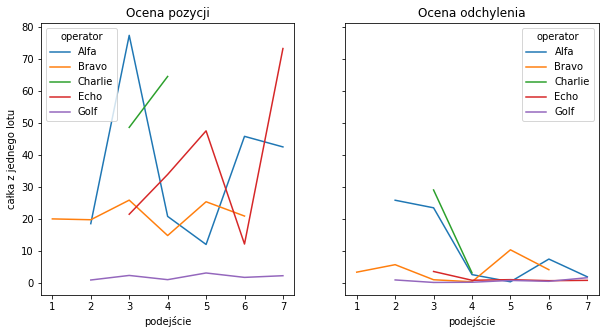

In [34]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122, sharey=ax)
hover.groupby(['operator', 'attempt']).grade_pos.sum().unstack(level=0).plot(kind='line', subplots=False, ax=ax, xlabel='podejście', ylabel='całka z jednego lotu', title='Ocena pozycji')
hover.groupby(['operator', 'attempt']).grade_yaw.sum().unstack(level=0).plot(kind='line', subplots=False, ax=ax2, xlabel='podejście', title='Ocena odchylenia')

plt.show()
save_img(f, 'ocena')


In [53]:
grades = hover.groupby(['operator', 'attempt']).grade_pos.sum().unstack(level=0) + \
         hover.groupby(['operator', 'attempt']).grade_yaw.sum().unstack(level=0)

print(grades.to_latex( float_format='%.2f'))
print(grades.mean())

\begin{tabular}{lrrrrr}
\toprule
operator &   Alfa &  Bravo &  Charlie &  Echo &  Golf \\
attempt &        &        &          &       &       \\
\midrule
1.0     &    NaN &  23.41 &      NaN &   NaN &   NaN \\
2.0     &  44.41 &  25.48 &      NaN &   NaN &  1.87 \\
3.0     & 100.92 &  26.90 &    77.72 & 25.08 &  2.52 \\
4.0     &  23.43 &  15.20 &    67.72 & 34.78 &  1.26 \\
5.0     &  12.41 &  35.76 &      NaN & 48.60 &  3.91 \\
6.0     &  53.31 &  25.07 &      NaN & 12.89 &  2.26 \\
7.0     &  44.46 &    NaN &      NaN & 74.11 &  3.91 \\
\bottomrule
\end{tabular}

operator
Alfa       46.490971
Bravo      25.303286
Charlie    72.718753
Echo       39.090531
Golf        2.621719
dtype: float64


In [36]:
fail = grades.max().max()
print('fail:\t', fail)
newbies = pd.concat([grades['Alfa'], grades['Charlie']]).append(pd.Series([fail]*6))
print('newbie:\t', newbies.mean())
auto = pd.concat([grades['Bravo'], grades['Echo']]).append(pd.Series([fail]*3))
print('auto:\t', auto.mean())
manual = grades['Golf']
print('manual:\t', manual.mean())

fail:	 100.91909548327024
newbie:	 73.56413589575388
auto:	 46.430689871620416
manual:	 2.6217186989135803


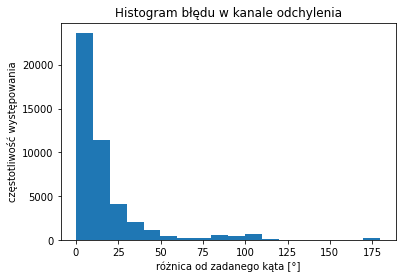

In [37]:
# hist = df.loc[(df.operator == 'Alfa') & (df.attempt == 5), :]
f = plt.gcf()
plt.hist(hover.penalty_yaw.abs(), bins=18)
plt.xlabel('różnica od zadanego kąta [°]')
plt.ylabel('częstotliwość występowania')
plt.title('Histogram błędu w kanale odchylenia')
plt.show()
save_img(f, 'yaw-histogram')

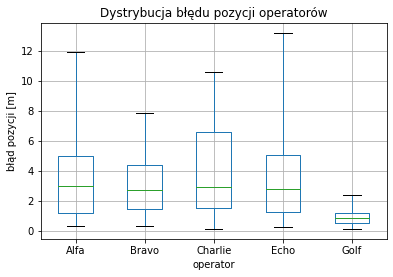

In [38]:
hover.boxplot(column='penalty_pos', by='operator', whis=(2, 98), sym='')
f = plt.gcf()
f.suptitle('')
plt.title('Dystrybucja błędu pozycji operatorów')
plt.ylabel('błąd pozycji [m]')
plt.xlabel('operator')
plt.show()
save_img(f, 'operator-pos-box')

In [39]:
a = hover.loc[hover.operator != 'Golf', :].groupby('operator').penalty_pos.median().min()
b = hover.loc[hover.operator != 'Golf', :].groupby('operator').penalty_pos.median().max()
print((a + b) / 2, (a - b) / 2)

2.877 -0.131


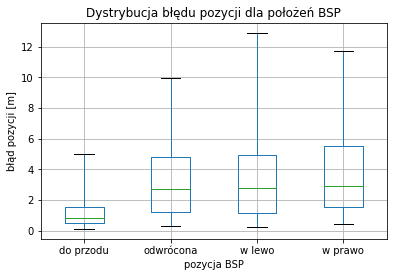

In [40]:
hover.boxplot(column='penalty_pos', by='direction', whis=(2, 98), sym='')
f = plt.gcf()
f.suptitle('')
plt.title('Dystrybucja błędu pozycji dla położeń BSP')
plt.ylabel('błąd pozycji [m]')
plt.xlabel('pozycja BSP')
plt.show()
save_img(f, 'orientation-pos-box')

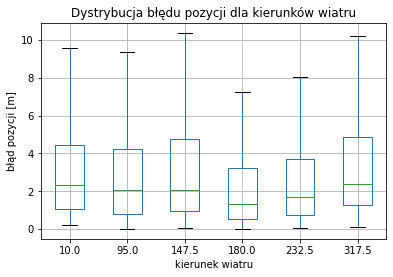

In [41]:
hover.boxplot(column='penalty_pos', by='wind', sym='')#, positions=[5,3,6,1,4,2])
f = plt.gcf()
f.suptitle('')
plt.title('Dystrybucja błędu pozycji dla kierunków wiatru')
plt.ylabel('błąd pozycji [m]')
plt.xlabel('kierunek wiatru')
plt.show()
save_img(f, 'wind-pos-box')

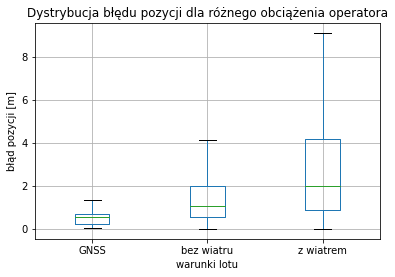

In [42]:
tasks = df.loc[df.task.isin(['GNSS', 'bez wiatru', 'z wiatrem']), :]
tasks.boxplot(column='penalty_pos', by='task', sym='')
f = plt.gcf()
f.suptitle('')
plt.title('Dystrybucja błędu pozycji dla różnego obciążenia operatora')
plt.ylabel('błąd pozycji [m]')
plt.xlabel('warunki lotu')
plt.show()
save_img(f, 'task-pos-box')

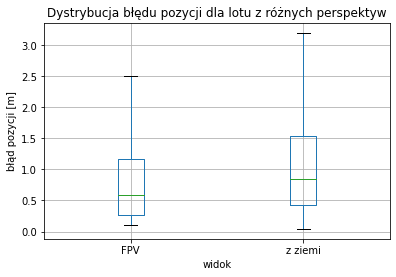

In [43]:
tasks = df.loc[df.task.isin(['FPV', 'z ziemi']), :]
tasks.boxplot(column='penalty_pos', by='task', sym='')
f = plt.gcf()
f.suptitle('')
plt.title('Dystrybucja błędu pozycji dla lotu z różnych perspektyw')
plt.ylabel('błąd pozycji [m]')
plt.xlabel('widok')
plt.show()
save_img(f, 'fpv-pos-box')

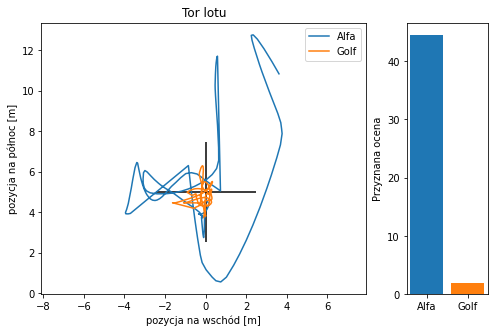

In [118]:
f, (ax, ax2) = plt.subplots(1, 2, figsize=(8,5), gridspec_kw={'width_ratios': [4, 1]})

df.loc[(df.operator == 'Alfa') & (df.attempt == 2), :].plot.line(x='positionY', y='positionX', label='Alfa', ax=ax)
df.loc[(df.operator == 'Golf') & (df.attempt == 2), :].plot.line(x='positionY', y='positionX', label='Golf', ax=ax)
ax.axis('equal')
ax.set_xlabel('pozycja na wschód [m]')
ax.set_ylabel('pozycja na północ [m]')
ax.set_title('Tor lotu')
ax.scatter(0, 5, zorder=0, marker='+', s=10000, color='black')

tmp = grades.unstack(level=0)
ax2.bar('Alfa', tmp.loc[['Alfa']][1])
ax2.bar('Golf', tmp.loc[['Golf']][1])
ax2.set_ylabel('Przyznana ocena')

plt.show()
save_img(f, 'weryfikacja')